In [1]:
from os.path import join
from tqdm import tqdm
import pandas as pd
import numpy as np
from py import util 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

DATA_DIR = 'data'

## 1. Load the data

In [2]:
WEEKS = range(1,2)

In [3]:
games = util.uncamelcase_columns(pd.read_csv(join(DATA_DIR, 'games.csv')))
games = games[games['week'].isin(WEEKS)].reset_index(drop=True)
game_ids = games['game_id'].unique()
games.head()

,game_id,season,week,game_date,game_time_eastern,home_team_abbr,visitor_team_abbr,home_final_score,visitor_final_score
0,2022090800,2022,1,9/8/2022,20:20:00,LA,BUF,10,31
1,2022091100,2022,1,9/11/2022,13:00:00,ATL,NO,26,27
2,2022091101,2022,1,9/11/2022,13:00:00,CAR,CLE,24,26
3,2022091102,2022,1,9/11/2022,13:00:00,CHI,SF,19,10
4,2022091103,2022,1,9/11/2022,13:00:00,CIN,PIT,20,23


In [4]:
cols = ['game_id', 'play_id', 'play_description', 'quarter', 'down',
       'yards_to_go', 'possession_team', 'defensive_team', 'game_clock', 
       'pre_snap_home_score', 'pre_snap_visitor_score', 
       'absolute_yardline_number', 'pre_snap_home_team_win_probability',
       'pre_snap_visitor_team_win_probability', 'expected_points',
       'offense_formation', 'receiver_alignment', 'play_clock_at_snap',
       'rush_location_type',
       'yards_gained', 'home_team_win_probability_added',
       'visitor_team_win_probility_added', 'expected_points_added',
       'pff_run_concept_primary',
       'pff_pass_coverage', 'pff_man_zone']

plays = (
    util.uncamelcase_columns(pd.read_csv(join(DATA_DIR, 'plays.csv')))
    .query('game_id.isin(@game_ids)')
    .query('pff_run_concept_primary.notnull() and ~pff_run_concept_primary.isin(["TRICK","UNDEFINED"])')
    .query('play_nullified_by_penalty == "N"')
    .query('yards_gained == pre_penalty_yards_gained')
    .query('qb_kneel == 0 and qb_sneak != True and qb_spike != True')
    .query('pass_result.isna() and is_dropback == False') # Designed runs only
    .query('pff_run_pass_option == 0')
    .query('dropback_type.isna()')
    .reset_index(drop=True)
    [cols]
)
plays.insert(0, 'game_play_id', plays['game_id'].astype(str) + '_' + plays['play_id'].astype(str))

game_play_ids = plays['game_play_id'].unique()

print(f'Number of non-RPO run plays: {len(game_play_ids)}')
print(plays.pff_run_concept_primary.value_counts())
plays.head()

Number of non-RPO run plays: 477
pff_run_concept_primary
OUTSIDE ZONE    156
INSIDE ZONE      96
MAN              93
PULL LEAD        44
COUNTER          35
POWER            29
TRAP             13
DRAW              9
FB RUN            2
Name: count, dtype: int64


,game_play_id,game_id,play_id,play_description,quarter,down,yards_to_go,possession_team,defensive_team,game_clock,pre_snap_home_score,pre_snap_visitor_score,absolute_yardline_number,pre_snap_home_team_win_probability,pre_snap_visitor_team_win_probability,expected_points,offense_formation,receiver_alignment,play_clock_at_snap,rush_location_type,yards_gained,home_team_win_probability_added,visitor_team_win_probility_added,expected_points_added,pff_run_concept_primary,pff_pass_coverage,pff_man_zone
0,2022091105_3712,2022091105,3712,(2:13) J.Taylor right guard to HST 15 for 14 y...,4,1,10,IND,HOU,02:13,20,13,81,0.778418,0.221582,3.682266,SINGLEBACK,3x1,20.0,INSIDE_LEFT,14,-0.064115,0.064115,1.109916,OUTSIDE ZONE,Cover-3,Zone
1,2022091104_1094,2022091104,1094,(12:56) D.Swift right end to DET 26 for 1 yard...,2,1,10,DET,PHI,12:56,7,7,35,0.395236,0.604764,1.608981,SINGLEBACK,2x2,5.0,INSIDE_RIGHT,1,-0.011404,0.011404,-0.539352,OUTSIDE ZONE,Quarters,Zone
2,2022091101_3923,2022091101,3923,(1:24) C.McCaffrey up the middle to CLV 15 for...,4,2,11,CAR,CLE,01:24,21,23,95,0.741719,0.258281,4.186713,SINGLEBACK,2x2,11.0,OUTSIDE_RIGHT,0,-0.094092,0.094092,-0.929233,INSIDE ZONE,Cover-1,Man
3,2022091100_501,2022091100,501,(7:46) A.Kamara left end to NO 28 for 5 yards ...,1,1,10,NO,ATL,07:46,3,0,87,0.381722,0.618278,1.365245,SINGLEBACK,3x1,19.0,INSIDE_LEFT,5,-0.007771,0.007771,0.087899,OUTSIDE ZONE,Cover-2,Zone
4,2022091110_729,2022091110,729,(3:20) (Shotgun) J.Conner up the middle to ARZ...,1,1,10,ARI,KC,03:20,0,14,35,0.075713,0.924287,1.270582,SHOTGUN,2x1,16.0,INSIDE_RIGHT,2,-0.002861,0.002861,-0.587148,OUTSIDE ZONE,Cover-3,Zone


In [5]:
tracking = pd.DataFrame()
for i in tqdm(WEEKS, desc='Loading tracking data', unit='file'):
    data = util.uncamelcase_columns(pd.read_csv(join(DATA_DIR, f'tracking_week_{i}.csv')))
    data.insert(
        0, 
        'game_play_id', 
        data['game_id'].astype(str) + '_' + data['play_id'].astype(str)
    )
    data = data.query('game_play_id in @game_play_ids').drop(columns=['jersey_number'])
    tracking = pd.concat([
        tracking,
        data
    ], ignore_index=True)

del data

tracking, plays = util.standardize_direction(tracking, plays)

tracking.head()

Loading tracking data: 100%|██████████| 1/1 [00:09<00:00,  9.18s/file]


,game_play_id,game_id,play_id,nfl_id,display_name,frame_id,frame_type,time,club,play_direction,x,y,s,a,dis,o,dir,event
0,2022091200_64,2022091200,64,35459.0,Kareem Jackson,1,BEFORE_SNAP,2022-09-13 00:16:03.5,DEN,right,24.75,51.06,0.72,0.37,0.07,293.83,111.66,huddle_break_offense
1,2022091200_64,2022091200,64,35459.0,Kareem Jackson,2,BEFORE_SNAP,2022-09-13 00:16:03.6,DEN,right,24.73,51.13,0.71,0.36,0.07,294.59,108.79,NaN
2,2022091200_64,2022091200,64,35459.0,Kareem Jackson,3,BEFORE_SNAP,2022-09-13 00:16:03.7,DEN,right,24.71,51.20,0.69,0.23,0.07,295.55,110.10,NaN
3,2022091200_64,2022091200,64,35459.0,Kareem Jackson,4,BEFORE_SNAP,2022-09-13 00:16:03.8,DEN,right,24.68,51.26,0.67,0.22,0.07,295.55,112.02,NaN
4,2022091200_64,2022091200,64,35459.0,Kareem Jackson,5,BEFORE_SNAP,2022-09-13 00:16:03.9,DEN,right,24.65,51.32,0.65,0.34,0.07,294.26,117.17,NaN


In [6]:
# only include tracking data for plays at or after the ball snap
ball_snap_frames = (
    tracking[tracking['event'] == 'ball_snap']
    .groupby('game_play_id')['frame_id']
    .min()
    .rename('ball_snap_frame_id')
)
tracking = tracking.merge(ball_snap_frames, on='game_play_id', how='left')
tracking = tracking[tracking['frame_id'] >= tracking['ball_snap_frame_id']].reset_index(drop=True)
tracking = tracking.drop(columns=['ball_snap_frame_id'])

In [7]:
players = util.uncamelcase_columns(pd.read_csv(join(DATA_DIR, 'players.csv')))
players.head()

,nfl_id,height,weight,birth_date,college_name,position,display_name
0,25511,6-4,225,1977-08-03,Michigan,QB,Tom Brady
1,29550,6-4,328,1982-01-22,Arkansas,T,Jason Peters
2,29851,6-2,225,1983-12-02,California,QB,Aaron Rodgers
3,30842,6-6,267,1984-05-19,UCLA,TE,Marcedes Lewis
4,33084,6-4,217,1985-05-17,Boston College,QB,Matt Ryan


In [8]:
player_play = util.uncamelcase_columns(pd.read_csv(join(DATA_DIR, 'player_play.csv')))
player_play.insert(0, 'game_play_id', player_play['game_id'].astype(str) + '_' + player_play['play_id'].astype(str))
player_play = player_play.query('game_play_id in @game_play_ids').reset_index(drop=True)
player_play.head()

,game_play_id,game_id,play_id,nfl_id,team_abbr,had_rush_attempt,rushing_yards,had_dropback,passing_yards,sack_yards_as_offense,had_pass_reception,receiving_yards,was_targetted_receiver,yardage_gained_after_the_catch,fumbles,fumble_lost,fumble_out_of_bounds,assisted_tackle,forced_fumble_as_defense,half_sack_yards_as_defense,pass_defensed,quarterback_hit,sack_yards_as_defense,safety_as_defense,solo_tackle,tackle_assist,tackle_for_a_loss,tackle_for_a_loss_yardage,had_interception,interception_yards,fumble_recoveries,fumble_recovery_yards,penalty_yards,penalty_names,was_initial_pass_rusher,caused_pressure,time_to_pressure_as_pass_rusher,get_off_time_as_pass_rusher,in_motion_at_ball_snap,shift_since_lineset,motion_since_lineset,was_running_route,route_ran,blocked_player_n_f_l_id1,blocked_player_n_f_l_id2,blocked_player_n_f_l_id3,pressure_allowed_as_blocker,time_to_pressure_allowed_as_blocker,pff_defensive_coverage_assignment,pff_primary_defensive_coverage_matchup_nfl_id,pff_secondary_defensive_coverage_matchup_nfl_id
0,2022090800_101,2022090800,101,35472,BUF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,False,NaN,NaN,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022090800_101,2022090800,101,42392,BUF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,False,NaN,NaN,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022090800_101,2022090800,101,42818,BUF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,False,NaN,NaN,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022090800_101,2022090800,101,44875,BUF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,False,NaN,NaN,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022090800_101,2022090800,101,46076,BUF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,False,NaN,NaN,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Metric Creation

In [9]:
tracking.head()

,game_play_id,game_id,play_id,nfl_id,display_name,frame_id,frame_type,time,club,play_direction,x,y,s,a,dis,o,dir,event
0,2022091200_64,2022091200,64,35459.0,Kareem Jackson,114,SNAP,2022-09-13 00:16:14.8,DEN,right,23.87,50.29,1.13,1.62,0.11,299.94,46.84,ball_snap
1,2022091200_64,2022091200,64,35459.0,Kareem Jackson,115,AFTER_SNAP,2022-09-13 00:16:14.9,DEN,right,23.96,50.39,1.37,1.61,0.13,299.94,48.81,NaN
2,2022091200_64,2022091200,64,35459.0,Kareem Jackson,116,AFTER_SNAP,2022-09-13 00:16:15,DEN,right,24.06,50.52,1.65,1.76,0.16,301.53,50.88,NaN
3,2022091200_64,2022091200,64,35459.0,Kareem Jackson,117,AFTER_SNAP,2022-09-13 00:16:15.1,DEN,right,24.18,50.67,1.99,1.94,0.20,304.34,51.68,NaN
4,2022091200_64,2022091200,64,35459.0,Kareem Jackson,118,AFTER_SNAP,2022-09-13 00:16:15.2,DEN,right,24.32,50.85,2.32,2.03,0.23,308.28,52.75,NaN


In [10]:
player_play.head()

,game_play_id,game_id,play_id,nfl_id,team_abbr,had_rush_attempt,rushing_yards,had_dropback,passing_yards,sack_yards_as_offense,had_pass_reception,receiving_yards,was_targetted_receiver,yardage_gained_after_the_catch,fumbles,fumble_lost,fumble_out_of_bounds,assisted_tackle,forced_fumble_as_defense,half_sack_yards_as_defense,pass_defensed,quarterback_hit,sack_yards_as_defense,safety_as_defense,solo_tackle,tackle_assist,tackle_for_a_loss,tackle_for_a_loss_yardage,had_interception,interception_yards,fumble_recoveries,fumble_recovery_yards,penalty_yards,penalty_names,was_initial_pass_rusher,caused_pressure,time_to_pressure_as_pass_rusher,get_off_time_as_pass_rusher,in_motion_at_ball_snap,shift_since_lineset,motion_since_lineset,was_running_route,route_ran,blocked_player_n_f_l_id1,blocked_player_n_f_l_id2,blocked_player_n_f_l_id3,pressure_allowed_as_blocker,time_to_pressure_allowed_as_blocker,pff_defensive_coverage_assignment,pff_primary_defensive_coverage_matchup_nfl_id,pff_secondary_defensive_coverage_matchup_nfl_id
0,2022090800_101,2022090800,101,35472,BUF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,False,NaN,NaN,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022090800_101,2022090800,101,42392,BUF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,False,NaN,NaN,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022090800_101,2022090800,101,42818,BUF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,False,NaN,NaN,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022090800_101,2022090800,101,44875,BUF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,False,NaN,NaN,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022090800_101,2022090800,101,46076,BUF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,False,NaN,NaN,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
players.head()

,nfl_id,height,weight,birth_date,college_name,position,display_name
0,25511,6-4,225,1977-08-03,Michigan,QB,Tom Brady
1,29550,6-4,328,1982-01-22,Arkansas,T,Jason Peters
2,29851,6-2,225,1983-12-02,California,QB,Aaron Rodgers
3,30842,6-6,267,1984-05-19,UCLA,TE,Marcedes Lewis
4,33084,6-4,217,1985-05-17,Boston College,QB,Matt Ryan


In [12]:
# Find distance from each player to the ball
ball_coords = (
    tracking.query('club=="football"')
    [['game_play_id', 'frame_id', 'x', 'y']]
    .rename(columns={'x': 'ball_x', 'y': 'ball_y'})
)
cols = ['euclidean_dist_to_ball', 'ball_x', 'ball_y', 'lateral_distance_to_ball', 'vertical_dist_to_ball']
for col in cols:
    if col in tracking.columns:
        tracking = tracking.drop(columns=[col])
tracking = tracking.merge(ball_coords, on=['game_play_id', 'frame_id'], how='left')
tracking['euclidean_dist_to_ball'] = (
    (tracking['x'] - tracking['ball_x']) ** 2 +
    (tracking['y'] - tracking['ball_y']) ** 2
) ** 0.5
tracking['euclidean_dist_to_ball'] = tracking['euclidean_dist_to_ball'].round(2)
tracking['lateral_distance_to_ball'] = (
    tracking['x'] - tracking['ball_x']
).round(2)
tracking['vertical_dist_to_ball'] = (
    tracking['y'] - tracking['ball_y']
).round(2)
tracking.drop(columns=['ball_x', 'ball_y'], inplace=True)
del ball_coords


# Label the ball carrier
cols = ['is_ball_carrier']
for col in cols:
    if col in tracking.columns:
        tracking = tracking.drop(columns=[col])
tracking = tracking.merge(
    player_play[['game_play_id', 'nfl_id', 'had_rush_attempt']]
    .query('had_rush_attempt == 1')
    .rename(columns={'had_rush_attempt': 'is_ball_carrier'}),
    on=['game_play_id', 'nfl_id'],
    how='left'
)
tracking['is_ball_carrier'] = tracking['is_ball_carrier'].fillna(0).astype(int)
# drop plays with multiple ball carriers or no ball carrier
n_ball_carriers = (
    tracking.query('frame_type=="SNAP"').groupby(['game_play_id'])['is_ball_carrier']
    .sum()
    .reset_index()
    .rename(columns={'is_ball_carrier': 'n_ball_carriers'})
)
tracking = tracking.merge(n_ball_carriers, on='game_play_id', how='left')
tracking = tracking.query('n_ball_carriers == 1').reset_index(drop=True).drop(columns=['n_ball_carriers'])
game_play_ids = tracking['game_play_id'].unique()
game_ids = tracking['game_id'].unique()
games = games.query('game_id in @game_ids').reset_index(drop=True)
plays = plays.query('game_play_id in @game_play_ids').reset_index(drop=True)
player_play = player_play.query('game_play_id in @game_play_ids').reset_index(drop=True)


# Join roster assigned positions
cols = ['roster_position']
for col in cols:
    if col in tracking.columns:
        tracking = tracking.drop(columns=[col])
tracking = tracking.merge(
    players[['nfl_id', 'position']],
    on='nfl_id',
    how='left'
).rename(columns={'position': 'roster_position'})
tracking['roster_position'] = np.where(
    tracking.display_name == "Taysom Hill",
    "TE",
    tracking.roster_position
)

tracking.head()

,game_play_id,game_id,play_id,nfl_id,display_name,frame_id,frame_type,time,club,play_direction,x,y,s,a,dis,o,dir,event,euclidean_dist_to_ball,lateral_distance_to_ball,vertical_dist_to_ball,is_ball_carrier,roster_position
0,2022091200_64,2022091200,64,35459.0,Kareem Jackson,114,SNAP,2022-09-13 00:16:14.8,DEN,right,23.87,50.29,1.13,1.62,0.11,299.94,46.84,ball_snap,12.91,-5.32,11.76,0,SS
1,2022091200_64,2022091200,64,35459.0,Kareem Jackson,115,AFTER_SNAP,2022-09-13 00:16:14.9,DEN,right,23.96,50.39,1.37,1.61,0.13,299.94,48.81,NaN,13.31,-5.24,12.23,0,SS
2,2022091200_64,2022091200,64,35459.0,Kareem Jackson,116,AFTER_SNAP,2022-09-13 00:16:15,DEN,right,24.06,50.52,1.65,1.76,0.16,301.53,50.88,NaN,13.74,-5.22,12.71,0,SS
3,2022091200_64,2022091200,64,35459.0,Kareem Jackson,117,AFTER_SNAP,2022-09-13 00:16:15.1,DEN,right,24.18,50.67,1.99,1.94,0.20,304.34,51.68,NaN,14.23,-5.27,13.22,0,SS
4,2022091200_64,2022091200,64,35459.0,Kareem Jackson,118,AFTER_SNAP,2022-09-13 00:16:15.2,DEN,right,24.32,50.85,2.32,2.03,0.23,308.28,52.75,NaN,14.82,-5.39,13.80,0,SS


In [13]:
# Drop plays without exactly 5 offensive linemen
offensive_line = ['T','G','C']
o_line = tracking[
    tracking['roster_position'].isin(offensive_line) &
    (tracking.frame_type == "SNAP")
]
o_line = o_line.groupby('game_play_id').size().reset_index(name='count')
o_line = o_line[o_line['count'] != 5]
drop_gid = o_line.game_play_id.unique().tolist()


print(f"Dropping {len(drop_gid)} plays without exactly 5 offensive linemen out of "
      "{len(tracking.game_play_id.unique())} total plays")
tracking = tracking[~tracking.game_play_id.isin(drop_gid)]
plays = plays[~plays.game_play_id.isin(drop_gid)]
player_play = player_play[~player_play.game_play_id.isin(drop_gid)]
games = games[games.game_id.isin(plays.game_id.unique())]

Dropping 20 plays without exactly 5 offensive linemen out of {len(tracking.game_play_id.unique())} total plays


In [14]:
tracking.head()

,game_play_id,game_id,play_id,nfl_id,display_name,frame_id,frame_type,time,club,play_direction,x,y,s,a,dis,o,dir,event,euclidean_dist_to_ball,lateral_distance_to_ball,vertical_dist_to_ball,is_ball_carrier,roster_position
0,2022091200_64,2022091200,64,35459.0,Kareem Jackson,114,SNAP,2022-09-13 00:16:14.8,DEN,right,23.87,50.29,1.13,1.62,0.11,299.94,46.84,ball_snap,12.91,-5.32,11.76,0,SS
1,2022091200_64,2022091200,64,35459.0,Kareem Jackson,115,AFTER_SNAP,2022-09-13 00:16:14.9,DEN,right,23.96,50.39,1.37,1.61,0.13,299.94,48.81,NaN,13.31,-5.24,12.23,0,SS
2,2022091200_64,2022091200,64,35459.0,Kareem Jackson,116,AFTER_SNAP,2022-09-13 00:16:15,DEN,right,24.06,50.52,1.65,1.76,0.16,301.53,50.88,NaN,13.74,-5.22,12.71,0,SS
3,2022091200_64,2022091200,64,35459.0,Kareem Jackson,117,AFTER_SNAP,2022-09-13 00:16:15.1,DEN,right,24.18,50.67,1.99,1.94,0.20,304.34,51.68,NaN,14.23,-5.27,13.22,0,SS
4,2022091200_64,2022091200,64,35459.0,Kareem Jackson,118,AFTER_SNAP,2022-09-13 00:16:15.2,DEN,right,24.32,50.85,2.32,2.03,0.23,308.28,52.75,NaN,14.82,-5.39,13.80,0,SS


In [25]:
# Label Offensive line positions

cols = ['game_play_id','frame_id','frame_type','nfl_id','roster_position','display_name','x','y','event']
lineman_and_qb = tracking[
    (tracking.frame_type == 'SNAP') & 
    tracking.roster_position.isin(offensive_line + ['QB'])
][cols]

lineman_and_qb['farthest_forward_lineman'] = (
    lineman_and_qb
    .query('roster_position != "QB"')
    .groupby('game_play_id')
    .y.transform('max')
)
lineman_and_qb['farthest_forward_lineman'] = np.where(
    lineman_and_qb.farthest_forward_lineman == lineman_and_qb.y,
    True,
    False
)

ball = (
    tracking.query('club == "football" and frame_type == "SNAP"')
    [['game_play_id','frame_id','x','y']]
    .rename(columns={'x': 'x_ball', 'y': 'y_ball'})
)
lineman_and_qb = lineman_and_qb.merge(ball, on='game_play_id')
lineman_and_qb['delta_ball'] = np.sqrt(
    (lineman_and_qb.x - lineman_and_qb.x_ball)**2 + 
    (lineman_and_qb.y - lineman_and_qb.y_ball)**2
)
lineman_and_qb['closest_to_ball'] = (
    lineman_and_qb
    .query('roster_position != "QB"')
    .groupby('game_play_id')
    .delta_ball.transform('min')
)
lineman_and_qb['closest_to_ball'] = np.where(
    lineman_and_qb.closest_to_ball == lineman_and_qb.delta_ball,
    True,
    False
)

# number the lineman from left to right by x position
lineman_and_qb = lineman_and_qb.sort_values(['game_play_id','x'])
position_map = {
    0: 'LT',
    1: 'LG',
    2: 'C',
    3: 'RG',
    4: 'RT'
}
lineman_and_qb.loc[lineman_and_qb.roster_position.isin(['T','C','G']),'position_by_loc'] = (
    lineman_and_qb
    .query('roster_position != "QB"')
    .groupby('game_play_id')
    .cumcount()
).replace(position_map)    

lineman_and_qb['is_center'] = np.where(
    (lineman_and_qb.closest_to_ball & (lineman_and_qb.position_by_loc=="C")), #| 
    True,
    False
)

plays_without_balanced_offensive_line = (
    lineman_and_qb
    .groupby('game_play_id')
    .is_center.sum().reset_index()
    .query('is_center != 1')
    .game_play_id.values.tolist()
)
if len(plays_without_balanced_offensive_line) != 0:
    print(f"Dropping {len(plays_without_balanced_offensive_line)} plays without a balanced offensive line.")
    print(plays_without_balanced_offensive_line)
    tracking = tracking[~tracking.game_play_id.isin(plays_without_balanced_offensive_line)]
    plays = plays[~plays.game_play_id.isin(plays_without_balanced_offensive_line)]
    player_play = player_play[~player_play.game_play_id.isin(plays_without_balanced_offensive_line)]
    games = games[games.game_id.isin(plays.game_id.unique())]
else:
    print("All plays have a balanced offensive line.")

# Create a new column for the position of the player based on the location of the player
tracking = (
    tracking
    .merge(
        lineman_and_qb[['game_play_id','nfl_id','position_by_loc']].drop_duplicates(),
        on=['game_play_id','nfl_id'],
        how='left'
    )
)
tracking['position_by_loc'] = np.where(
    tracking.position_by_loc.isna(),
    tracking.roster_position,
    tracking.position_by_loc
)

Dropping 18 plays without a balanced offensive line.
['2022091101_2386', '2022091102_322', '2022091102_3981', '2022091102_467', '2022091104_2269', '2022091104_4410', '2022091104_999', '2022091105_1309', '2022091105_1351', '2022091105_294', '2022091105_3366', '2022091105_4512', '2022091108_1089', '2022091108_2724', '2022091109_1636', '2022091109_3463', '2022091109_656', '2022091111_2901']


In [40]:
tracking.roster_position.unique()

array(['SS', 'QB', 'G', 'CB', 'OLB', 'WR', 'DE', 'ILB', 'FS', 'C', 'NT',
       'RB', 'TE', 'T', nan, 'DT', 'MLB', 'FB', 'LB', 'DB'], dtype=object)

In [48]:
offense_positions = ['QB', 'RB', 'FB', 'WR', 'TE', 'G', 'C', 'T']
defense_positions = ['DE', 'DT', 'NT', 'OLB', 'ILB', 'MLB', 'CB', 'SS', 'FS', 'DB', 'LB']

if tracking.roster_position.nunique() != len(offense_positions + defense_positions):
    raise Exception("There are players with positions not in the offense or defense position lists.")

tracking['offense'] = np.where(
    tracking.roster_position.isin(offense_positions),
    1,
    0
)

### Identify players that are an extension of the core 5 olineman

In [ ]:
cols = ['y_min_oline_left', 'y_min_oline_right', 'extra_on_oline', 
        'extra_oline_box_left', 'extra_oline_box_right', 'oline_box_left', 
        'oline_box_right', 'center_x_at_ball_snap']
for col in cols:
    if col in tracking.columns:
        tracking = tracking.drop(columns=[col])

oline_box_at_snap = (
    tracking
    .query('position_by_loc in ["LT","RT"] and frame_type == "SNAP"')
    [['game_play_id','position_by_loc','x']]
)

# Add oline_box_left (at the snap)
tracking = (
    tracking
    .merge(
        (
            oline_box_at_snap
            .query('position_by_loc=="LT"')
            [['game_play_id','x']]
            .rename(columns={'x':'oline_box_left'})
        ), 
        on='game_play_id', 
        how='left'
    )
)

# Add oline_box_right (at the snap)
tracking = (
    tracking
    .merge(
        (
            oline_box_at_snap
            .query('position_by_loc=="RT"')
            [['game_play_id','x']]
            .rename(columns={'x':'oline_box_right'})
        ),
        on='game_play_id',
        how='left'
    )
)

# Add center_x_at_ball_snap
tracking = (
    tracking
    .merge(
        (
            tracking
            .query('position_by_loc == "C" and frame_type == "SNAP"')
            .rename(columns={'x':'center_x_at_ball_snap'})
            [['game_play_id','center_x_at_ball_snap']]
            .drop_duplicates()
        ),
        on='game_play_id',
        how='left'
    )
)

extra_on_oline = tracking.query('frame_type == "SNAP"')
y_min_oline_left = extra_on_oline.query('position_by_loc.isin(["LT","LG","C"])').groupby('game_play_id').y.min().reset_index()
y_min_oline_right = extra_on_oline.query('position_by_loc.isin(["RT","RG","C"])').groupby('game_play_id').y.min().reset_index()
extra_on_oline = extra_on_oline.merge(y_min_oline_left, on='game_play_id', suffixes=('','_min_oline_left'))
extra_on_oline = extra_on_oline.merge(y_min_oline_right, on='game_play_id', suffixes=('','_min_oline_right'))

extra_on_oline = extra_on_oline[extra_on_oline['offense'] == 1]
left_condition = (
    (extra_on_oline['x'] < extra_on_oline['oline_box_left']) & 
    (extra_on_oline['x'] > extra_on_oline['oline_box_left'] - 2) & 
    (extra_on_oline['y'] > extra_on_oline['y_min_oline_left'] - 0.1)
)
right_condition = (
    (extra_on_oline['x'] > extra_on_oline['oline_box_right']) & 
    (extra_on_oline['x'] < extra_on_oline['oline_box_right'] + 2) & 
    (extra_on_oline['y'] > extra_on_oline['y_min_oline_right'] - 0.1)
)
extra_on_oline = extra_on_oline[left_condition | right_condition]
extra_on_oline = extra_on_oline.drop_duplicates()[['game_play_id', 'nfl_id', 'x', 'y_min_oline_left', 
                                                  'y_min_oline_right', 'oline_box_left', 'oline_box_right']]

extra_on_oline['extra_on_oline'] = True
extra_on_oline['extra_oline_box_left'] = np.where(
    extra_on_oline['x'] < extra_on_oline['oline_box_left'],
    extra_on_oline['x'],
    None
)

extra_on_oline['extra_on_oline'] = True
extra_on_oline['extra_oline_box_left'] = np.where(
    extra_on_oline['x'] < extra_on_oline['oline_box_left'],
    extra_on_oline['x'],
    None
)
extra_on_oline['extra_oline_box_right'] = np.where(
    extra_on_oline['x'] > extra_on_oline['oline_box_right'],
    extra_on_oline['x'],
    None
)

# Merge extra oline data to the tracking data
if 'extra_on_oline' in tracking.columns:
    tracking.drop(columns='extra_on_oline', inplace=True)
if 'extra_oline_box_left' in tracking.columns:
    tracking.drop(columns='extra_oline_box_left', inplace=True)
if 'extra_oline_box_right' in tracking.columns:
    tracking.drop(columns='extra_oline_box_right', inplace=True)
if 'y_min_oline_left' in tracking.columns:
    tracking.drop(columns='y_min_oline_left', inplace=True)
if 'y_min_oline_right' in tracking.columns:
    tracking.drop(columns='y_min_oline_right', inplace=True)
tracking = tracking.merge(
    extra_on_oline[['game_play_id','nfl_id','y_min_oline_left','y_min_oline_right',
                    'extra_on_oline','extra_oline_box_left','extra_oline_box_right']],
    on=['game_play_id','nfl_id'], 
    how='left'
)
tracking['extra_oline_box_left'] = tracking.groupby('game_play_id')['extra_oline_box_left'].transform('max')
tracking['extra_oline_box_right'] = tracking.groupby('game_play_id')['extra_oline_box_right'].transform('max')
tracking['extra_oline_box_left'] = tracking['extra_oline_box_left'].fillna(tracking['oline_box_left'])
tracking['extra_oline_box_right'] = tracking['extra_oline_box_right'].fillna(tracking['oline_box_right'])
tracking['extra_on_oline'] = tracking['extra_on_oline'].fillna(False)

# Repeat the process for extra oline outside of the additional oline box
extra_on_oline = tracking.query('extra_on_oline and frame_type == "SNAP"')
extra_on_oline = extra_on_oline.query(
    'offense and ' +\
    '((~extra_oline_box_left.isna() and x < extra_oline_box_left and x > extra_oline_box_left - 2 and y > y_min_oline_left - 0.1) or ' +\
    ' (~extra_oline_box_right.isna() and x > extra_oline_box_right and x < extra_oline_box_right + 2 and y > y_min_oline_right - 0.1))',
    engine='python'
).drop_duplicates()[['game_play_id','nfl_id','x','y_min_oline_left','y_min_oline_right','extra_oline_box_left','extra_oline_box_right']]

extra_on_oline['extra_on_oline'] = True
extra_on_oline['extra_oline_box_left'] = np.where(
    extra_on_oline['x'] < extra_on_oline['extra_oline_box_left'],
    extra_on_oline['x'],
    None
)
extra_on_oline['extra_oline_box_right'] = np.where(
    extra_on_oline['x'] > extra_on_oline['extra_oline_box_right'],
    extra_on_oline['x'],
    None
)

if not extra_on_oline.empty:
    tracking = tracking.merge(
        extra_on_oline[['game_play_id','nfl_id',
                        'extra_on_oline','extra_oline_box_left','extra_oline_box_right']],
        on=['game_play_id','nfl_id'], 
        how='left',
        suffixes=('','_x')
    )

    tracking['extra_oline_box_left_x'] = tracking.groupby('game_play_id')['extra_oline_box_left_x'].transform('max')
    tracking['extra_oline_box_right_x'] = tracking.groupby('game_play_id')['extra_oline_box_right_x'].transform('max')
    tracking['extra_on_oline_x'] = tracking['extra_on_oline_x'].fillna(False)

    tracking['extra_on_oline'] = tracking['extra_on_oline'] | tracking['extra_on_oline_x']
    tracking['extra_oline_box_left'] = tracking['extra_oline_box_left'].fillna(tracking['extra_oline_box_left_x'])
    tracking['extra_oline_box_right'] = tracking['extra_oline_box_right'].fillna(tracking['extra_oline_box_right_x'])

    tracking.drop(columns=['extra_on_oline_x','extra_oline_box_left_x','extra_oline_box_right_x'], inplace=True)

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_74176/3345445248.py:119: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tracking['extra_oline_box_left'] = tracking['extra_oline_box_left'].fillna(tracking['oline_box_left'])
/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_74176/3345445248.py:120: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tracking['extra_oline_box_right'] = tracking['extra_oline_box_right'].fillna(tracking['oline_box_right'])
/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_74176/3345445248.py:121: FutureW

In [70]:
drop_col = ['extra_oline_box_left','extra_oline_box_right', 'y_min_oline_right', 
            'y_min_oline_left', 'oline_box_left', 'oline_box_right', 'center_x_at_ball_snap']

tracking.drop(columns=drop_col, inplace=True)

In [73]:
tracking['is_part_of_oline'] = np.where(
    tracking['position_by_loc'].isin(['LT','LG','C','RG','RT']) | tracking['extra_on_oline'],
    True,
    False
)

In [74]:
tracking.head()

,game_play_id,game_id,play_id,nfl_id,display_name,frame_id,frame_type,time,club,play_direction,x,y,s,a,dis,o,dir,event,euclidean_dist_to_ball,lateral_distance_to_ball,vertical_dist_to_ball,is_ball_carrier,roster_position,position_by_loc,offense,extra_on_oline,is_part_of_oline
0,2022091200_64,2022091200,64,35459.0,Kareem Jackson,114,SNAP,2022-09-13 00:16:14.8,DEN,right,23.87,50.29,1.13,1.62,0.11,299.94,46.84,ball_snap,12.91,-5.32,11.76,0,SS,SS,0,False,False
1,2022091200_64,2022091200,64,35459.0,Kareem Jackson,115,AFTER_SNAP,2022-09-13 00:16:14.9,DEN,right,23.96,50.39,1.37,1.61,0.13,299.94,48.81,NaN,13.31,-5.24,12.23,0,SS,SS,0,False,False
2,2022091200_64,2022091200,64,35459.0,Kareem Jackson,116,AFTER_SNAP,2022-09-13 00:16:15,DEN,right,24.06,50.52,1.65,1.76,0.16,301.53,50.88,NaN,13.74,-5.22,12.71,0,SS,SS,0,False,False
3,2022091200_64,2022091200,64,35459.0,Kareem Jackson,117,AFTER_SNAP,2022-09-13 00:16:15.1,DEN,right,24.18,50.67,1.99,1.94,0.20,304.34,51.68,NaN,14.23,-5.27,13.22,0,SS,SS,0,False,False
4,2022091200_64,2022091200,64,35459.0,Kareem Jackson,118,AFTER_SNAP,2022-09-13 00:16:15.2,DEN,right,24.32,50.85,2.32,2.03,0.23,308.28,52.75,NaN,14.82,-5.39,13.80,0,SS,SS,0,False,False


In [137]:
np.argmax(hull_points[:,1:])

np.int64(2)

In [142]:
hull_points.sort(axis=0)

In [143]:
hull_points

array([[23.58, 48.91],
       [24.69, 52.74],
       [28.86, 55.2 ],
       [30.84, 56.05],
       [31.12, 58.14]])

In [144]:
hull_points[np.argmax(hull_points[:,1:])][0]

np.float64(31.12)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon

def find_front_edges(hull_points):
    """Identify front edges of convex hull (top edges)"""
    edges = []

    leading_point_x = hull_points[np.argmax(hull_points[:,1:])][0]

    
    for i in range(len(hull_points)):
        p1 = hull_points[i]
        p2 = hull_points[(i+1)%len(hull_points)]
        # Front edges are those where both points are on the top side
        # Since play direction is upward, top edges are horizontal or upward-facing
        if p1[1] == p2[1] or (p1[1] > p2[1] and p1[0] < p2[0]) or (p1[1] < p2[1] and p1[0] > p2[0]):
            edges.append((p1, p2))
    return edges

def point_above_line(point, line):
    """Check if point is above a line segment"""
    (x1, y1), (x2, y2) = line
    if x1 == x2:  # vertical line
        return point[0] == x1 and point[1] >= min(y1, y2)
    else:
        # Calculate line equation: y = mx + b
        m = (y2 - y1) / (x2 - x1)
        b = y1 - m * x1
        # Check if point is above the line
        return point[1] >= m * point[0] + b

def find_rb_breakthrough_frames(tracking_df):
    # Create new column for breakthrough frame
    tracking_df['rb_breakthrough_frame'] = np.nan
    
    # Get unique plays
    unique_plays = tracking_df['game_play_id'].unique()
    
    # For animation example
    example_play = None
    example_frames = []
    example_breakthrough_frame = None
    
    for play in tqdm(unique_plays, desc='Finding RB breakthrough frames'):
        play_df = tracking_df[tracking_df['game_play_id'] == play].copy()
        frames = play_df['frame_id'].unique()
        
        # Find RB in this play (assuming RB is the ball carrier)
        rb_id = play_df[play_df['is_ball_carrier'] == 1]['nfl_id'].iloc[0]
        
        breakthrough_found = False
        breakthrough_frame = None
        
        for frame in sorted(frames):
            frame_df = play_df[play_df['frame_id'] == frame]
            
            # Get o-line players
            oline_df = frame_df[frame_df['is_part_of_oline'] == True]
            if len(oline_df) < 3:  # Need at least 3 points for convex hull
                continue
                
            # Get RB position
            rb_pos = frame_df[frame_df['nfl_id'] == rb_id][['x', 'y']].values
            if len(rb_pos) == 0:
                continue
            rb_pos = rb_pos[0]
            
            # Create convex hull for o-line
            oline_points = oline_df[['x', 'y']].values
            try:
                hull = ConvexHull(oline_points)
            except:
                continue
                
            # Get hull points in order
            hull_points = oline_points[hull.vertices]
            
            # Find front edges
            front_edges = find_front_edges(hull_points)
            
            # Check if RB is ahead of all o-line players
            if rb_pos[1] > oline_points[:, 1].max():
                breakthrough_frame = frame
                breakthrough_found = True
                break
                
            # Check if RB passes through any front edge
            for edge in front_edges:
                if point_above_line(rb_pos, edge):
                    breakthrough_frame = frame
                    breakthrough_found = True
                    break
            if breakthrough_found:
                break
                
        # Update breakthrough frame for all rows in this play
        if breakthrough_found:
            tracking_df.loc[tracking_df['game_play_id'] == play, 'rb_breakthrough_frame'] = breakthrough_frame
            
            # Store first example for animation
            if example_play is None:
                example_play = play
                example_frames = play_df
                example_breakthrough_frame = breakthrough_frame
    
    return tracking_df, example_play, example_frames, example_breakthrough_frame

def create_animation(play_df, breakthrough_frame):
    fig, ax = plt.subplots(figsize=(10, 8))
    frames = sorted(play_df['frame_id'].unique())
    
    def update(frame_num):
        ax.clear()
        frame_df = play_df[play_df['frame_id'] == frames[frame_num]]
        
        # Plot all players
        for club, color in [('offense', 'blue'), ('defense', 'red'), ('football', 'yellow')]:
            club_df = frame_df[frame_df['club'] == club]
            if not club_df.empty:
                ax.scatter(club_df['x'], club_df['y'], color=color, label=club)
        
        # Highlight RB
        rb_df = frame_df[frame_df['is_ball_carrier'] == 1]
        if not rb_df.empty:
            ax.scatter(rb_df['x'], rb_df['y'], color='green', s=100, label='RB')
        
        # Draw convex hull for o-line
        oline_df = frame_df[frame_df['is_part_of_oline'] == True]
        if len(oline_df) >= 3:
            oline_points = oline_df[['x', 'y']].values
            try:
                hull = ConvexHull(oline_points)
                hull_points = oline_points[hull.vertices]
                hull_poly = Polygon(hull_points, fill=False, edgecolor='blue', linestyle='--', linewidth=2)
                ax.add_patch(hull_poly)
                
                # Highlight front edges
                front_edges = find_front_edges(hull_points)
                for edge in front_edges:
                    ax.plot([edge[0][0], edge[1][0]], [edge[0][1], edge[1][1]], 
                            color='orange', linewidth=3, linestyle='-')
            except:
                pass
        
        # Highlight breakthrough frame
        if frames[frame_num] == breakthrough_frame:
            ax.set_title(f"Frame {frames[frame_num]} - RB BREAKTHROUGH!", color='red', fontsize=14)
        else:
            ax.set_title(f"Frame {frames[frame_num]}")
        
        ax.set_xlim(play_df['x'].min() - 5, play_df['x'].max() + 5)
        ax.set_ylim(play_df['y'].min() - 5, play_df['y'].max() + 5)
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.legend()
        ax.grid(True)
    
    ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=200)
    plt.close()
    return ani

# Process the tracking data
tracking_with_breakthrough, example_play, example_frames, example_breakthrough = find_rb_breakthrough_frames(tracking)

# Create animation for example play
if example_play:
    print(f"Example play: {example_play}")
    print(f"Breakthrough frame: {example_breakthrough}")
    ani = create_animation(example_frames, example_breakthrough)
    # To display in Jupyter notebook:
    # from IPython.display import HTML
    # HTML(ani.to_jshtml())
else:
    print("No plays with RB breakthrough found.")

HTML(ani.to_jshtml())

Finding RB breakthrough frames: 100%|██████████| 438/438 [00:19<00:00, 22.71it/s]


Example play: 2022091200_64
Breakthrough frame: 141


In [151]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.neighbors import NearestNeighbors

def calculate_field_control(tracking_df):
    """
    Calculate field control metrics for offensive linemen during running plays
    Returns DataFrame with lineman grades and detailed metrics
    """
    
    # Create output DataFrame
    results = []
    
    # Get all running plays (where is_ball_carrier exists)
    running_plays = tracking_df[tracking_df['is_ball_carrier'] == 1]['game_play_id'].unique()
    
    for play in tqdm(running_plays, desc='Calculating field control'):
        play_df = tracking_df[tracking_df['game_play_id'] == play].copy()
        
        # Get frames from snap to RB breakthrough
        snap_frame = play_df[play_df['event'] == 'ball_snap']['frame_id'].min()
        breakthrough_frame = play_df['rb_breakthrough_frame'].min()
        
        if pd.isna(breakthrough_frame):
            breakthrough_frame = play_df['frame_id'].max()  # Use entire play if no breakthrough
            
        play_frames = play_df[(play_df['frame_id'] >= snap_frame) & 
                             (play_df['frame_id'] <= breakthrough_frame)]
        
        # Get key players
        rb_df = play_frames[play_frames['is_ball_carrier'] == 1]
        oline = play_frames[play_frames['is_part_of_oline'] == True]
        defenders = play_frames[(play_frames['club'].isin(['DEF', 'defense'])) & 
                              (~play_frames['is_part_of_oline'])]
        
        if len(oline) == 0 or len(rb_df) == 0:
            continue
            
        # Calculate influence for each frame
        for frame in play_frames['frame_id'].unique():
            frame_df = play_frames[play_frames['frame_id'] == frame]
            
            # Get current positions
            rb_pos = rb_df[rb_df['frame_id'] == frame][['x', 'y']].values
            if len(rb_pos) == 0:
                continue
            rb_pos = rb_pos[0]
            rb_dir = rb_df[rb_df['frame_id'] == frame]['dir'].values[0]
            
            oline_frame = oline[oline['frame_id'] == frame]
            def_frame = defenders[defenders['frame_id'] == frame]
            
            # Create grid for field control calculation
            x_min, x_max = play_frames['x'].min() - 5, play_frames['x'].max() + 5
            y_min, y_max = play_frames['y'].min() - 5, play_frames['y'].max() + 5
            x_grid = np.linspace(x_min, x_max, 50)
            y_grid = np.linspace(y_min, y_max, 50)
            xx, yy = np.meshgrid(x_grid, y_grid)
            grid_points = np.vstack([xx.ravel(), yy.ravel()]).T
            
            # Calculate RB direction vector (convert degrees to radians)
            rb_dir_rad = np.deg2rad(rb_dir)
            rb_direction = np.array([np.sin(rb_dir_rad), np.cos(rb_dir_rad)])
            
            # For each o-lineman, find closest defender and calculate influence
            for _, olineman in oline_frame.iterrows():
                o_pos = olineman[['x', 'y']].values
                
                # Find closest defender
                if len(def_frame) > 0:
                    def_positions = def_frame[['x', 'y']].values
                    nbrs = NearestNeighbors(n_neighbors=1).fit(def_positions)
                    distances, indices = nbrs.kneighbors([o_pos])
                    closest_def = def_frame.iloc[indices[0][0]]
                    d_pos = closest_def[['x', 'y']].values
                else:
                    d_pos = o_pos  # Fallback if no defenders
                
                # Calculate influence for o-lineman and defender
                o_influence = multivariate_normal(mean=o_pos, cov=[[1, 0], [0, 1]])
                d_influence = multivariate_normal(mean=d_pos, cov=[[1, 0], [0, 1]])
                
                # Calculate RB-direction weighted influence
                grid_vectors = grid_points - rb_pos
                grid_vectors_norm = grid_vectors / np.linalg.norm(grid_vectors, axis=1)[:, np.newaxis]
                direction_weights = np.dot(grid_vectors_norm, rb_direction)
                direction_weights = (direction_weights + 1) / 2  # Scale to 0-1
                
                # Calculate field control
                o_pdf = o_influence.pdf(grid_points).reshape(xx.shape)
                d_pdf = d_influence.pdf(grid_points).reshape(xx.shape)
                
                # Apply direction weights
                o_pdf_weighted = o_pdf * direction_weights.reshape(xx.shape)
                d_pdf_weighted = d_pdf * direction_weights.reshape(xx.shape)
                
                # Calculate control ratio
                control_ratio = o_pdf_weighted / (o_pdf_weighted + d_pdf_weighted + 1e-10)
                
                # Identify gap area (region between linemen)
                # This requires identifying adjacent linemen - simplified here
                gap_area = np.zeros_like(control_ratio)
                
                # For simplicity, we'll define gap as area in front of lineman
                front_mask = (grid_points[:, 1] > o_pos[1]).reshape(xx.shape)
                gap_control = np.mean(control_ratio[front_mask]) if np.any(front_mask) else 0
                
                # Store results
                results.append({
                    'game_play_id': play,
                    'nfl_id': olineman['nfl_id'],
                    'display_name': olineman['display_name'],
                    'frame_id': frame,
                    'olineman_x': o_pos[0],
                    'olineman_y': o_pos[1],
                    'closest_defender': closest_def['nfl_id'] if len(def_frame) > 0 else None,
                    'defender_x': d_pos[0],
                    'defender_y': d_pos[1],
                    'rb_x': rb_pos[0],
                    'rb_y': rb_pos[1],
                    'rb_dir': rb_dir,
                    'gap_control_pct': gap_control,
                    'field_control_score': np.mean(control_ratio),
                    'direction_weighted_score': np.mean(o_pdf_weighted)
                })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Aggregate scores by lineman per play
    lineman_grades = results_df.groupby(['game_play_id', 'nfl_id', 'display_name']).agg({
        'gap_control_pct': 'mean',
        'field_control_score': 'mean',
        'direction_weighted_score': 'mean',
        'frame_id': 'count'  # Number of frames analyzed
    }).reset_index()
    
    # Normalize scores across all plays
    for metric in ['gap_control_pct', 'field_control_score', 'direction_weighted_score']:
        lineman_grades[f'normalized_{metric}'] = (
            lineman_grades[metric] - lineman_grades[metric].min()
        ) / (lineman_grades[metric].max() - lineman_grades[metric].min())
    
    # Calculate overall grade (weighted average)
    weights = {
        'gap_control_pct': 0.4,
        'field_control_score': 0.3,
        'direction_weighted_score': 0.3
    }
    lineman_grades['overall_grade'] = (
        lineman_grades['normalized_gap_control_pct'] * weights['gap_control_pct'] +
        lineman_grades['normalized_field_control_score'] * weights['field_control_score'] +
        lineman_grades['normalized_direction_weighted_score'] * weights['direction_weighted_score']
    )
    
    return lineman_grades, results_df

In [153]:
lineman_grades, results_df = calculate_field_control(tracking)

Calculating field control: 100%|██████████| 438/438 [00:37<00:00, 11.83it/s]


In [156]:
lineman_grades.sort_values(by='overall_grade', ascending=False).head(10)

,game_play_id,nfl_id,display_name,gap_control_pct,field_control_score,direction_weighted_score,frame_id,normalized_gap_control_pct,normalized_field_control_score,normalized_direction_weighted_score,overall_grade
1768,2022091110_994,46103.0,Will Hernandez,0.118502,0.103644,0.001469,22,0.928084,1.000000,0.995115,0.969768
1764,2022091110_994,37130.0,Rodney Hudson,0.113915,0.101209,0.001354,22,0.885391,0.968164,0.916925,0.919683
1765,2022091110_994,38779.0,Kelvin Beachum,0.104025,0.103128,0.001477,22,0.793333,0.993260,1.000000,0.915311
1766,2022091110_994,42367.0,D.J. Humphries,0.126229,0.100237,0.001080,22,1.000000,0.955450,0.730296,0.905724
1767,2022091110_994,44949.0,Sean Harlow,0.113498,0.100451,0.001196,22,0.881508,0.958245,0.808930,0.882756
642,2022091103_1700,43510.0,Ted Karras,0.095948,0.091148,0.001121,42,0.718159,0.836612,0.758343,0.765750
643,2022091103_1700,46163.0,Alex Cappa,0.090684,0.090834,0.001068,42,0.669160,0.832501,0.722007,0.734016
1366,2022091107_330,54490.0,Tyler Linderbaum,0.085638,0.087374,0.001222,17,0.622194,0.787270,0.827131,0.733198
800,2022091104_1660,43368.0,Isaac Seumalo,0.085577,0.085682,0.001164,21,0.621632,0.765142,0.787399,0.714415
799,2022091104_1660,39950.0,Lane Johnson,0.085270,0.086746,0.001147,21,0.618775,0.779050,0.775758,0.713952


In [ ]:
def visualize_play_control(play_results_df, frame_num):
    """Visualize field control for a specific frame"""
    frame_df = play_results_df[play_results_df['frame_id'] == frame_num].iloc[0]
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create grid for visualization
    x_grid = np.linspace(frame_df['olineman_x'] - 5, frame_df['olineman_x'] + 5, 50)
    y_grid = np.linspace(frame_df['olineman_y'] - 5, frame_df['olineman_y'] + 5, 50)
    xx, yy = np.meshgrid(x_grid, y_grid)
    
    # Recalculate control for visualization
    o_pos = np.array([frame_df['olineman_x'], frame_df['olineman_y']])
    d_pos = np.array([frame_df['defender_x'], frame_df['defender_y']])
    rb_pos = np.array([frame_df['rb_x'], frame_df['rb_y']])
    rb_dir_rad = np.deg2rad(frame_df['rb_dir'])
    rb_direction = np.array([np.sin(rb_dir_rad), np.cos(rb_dir_rad)])
    
    grid_points = np.vstack([xx.ravel(), yy.ravel()]).T
    grid_vectors = grid_points - rb_pos
    grid_vectors_norm = grid_vectors / np.linalg.norm(grid_vectors, axis=1)[:, np.newaxis]
    direction_weights = np.dot(grid_vectors_norm, rb_direction)
    direction_weights = (direction_weights + 1) / 2
    
    o_influence = multivariate_normal(mean=o_pos, cov=[[1, 0], [0, 1]])
    d_influence = multivariate_normal(mean=d_pos, cov=[[1, 0], [0, 1]])
    
    o_pdf = o_influence.pdf(grid_points).reshape(xx.shape)
    d_pdf = d_influence.pdf(grid_points).reshape(xx.shape)
    control_ratio = o_pdf / (o_pdf + d_pdf + 1e-10)
    
    # Plot field control
    control_plot = ax.pcolormesh(xx, yy, control_ratio, cmap='coolwarm', vmin=0, vmax=1, alpha=0.6)
    fig.colorbar(control_plot, label='Control Ratio (O-line/D)')
    
    # Plot players  
    ax.scatter(o_pos[0], o_pos[1], color='blue', s=100, label='O-lineman')
    ax.scatter(d_pos[0], d_pos[1], color='red', s=100, label='Defender')
    ax.scatter(rb_pos[0], rb_pos[1], color='green', s=100, label='RB')
    
    # Plot RB direction
    ax.quiver(rb_pos[0], rb_pos[1], 
              rb_direction[0], rb_direction[1],
              color='green', scale=10, width=0.005)
    
    ax.set_title(f"Field Control Analysis\n{frame_df['display_name']} vs Defender (Frame {frame_num})")
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.legend()
    plt.tight_layout()
    plt.show()

Calculating field control: 100%|██████████| 438/438 [00:36<00:00, 12.05it/s]


         game_play_id   nfl_id      display_name  gap_control_pct  \
1768   2022091110_994  46103.0    Will Hernandez         0.118502   
1764   2022091110_994  37130.0     Rodney Hudson         0.113915   
1765   2022091110_994  38779.0    Kelvin Beachum         0.104025   
1766   2022091110_994  42367.0    D.J. Humphries         0.126229   
1767   2022091110_994  44949.0       Sean Harlow         0.113498   
642   2022091103_1700  43510.0        Ted Karras         0.095948   
643   2022091103_1700  46163.0        Alex Cappa         0.090684   
1366   2022091107_330  54490.0  Tyler Linderbaum         0.085638   
800   2022091104_1660  43368.0     Isaac Seumalo         0.085577   
799   2022091104_1660  39950.0      Lane Johnson         0.085270   

      field_control_score  direction_weighted_score  frame_id  \
1768             0.103644                  0.001469        22   
1764             0.101209                  0.001354        22   
1765             0.103128                  0.

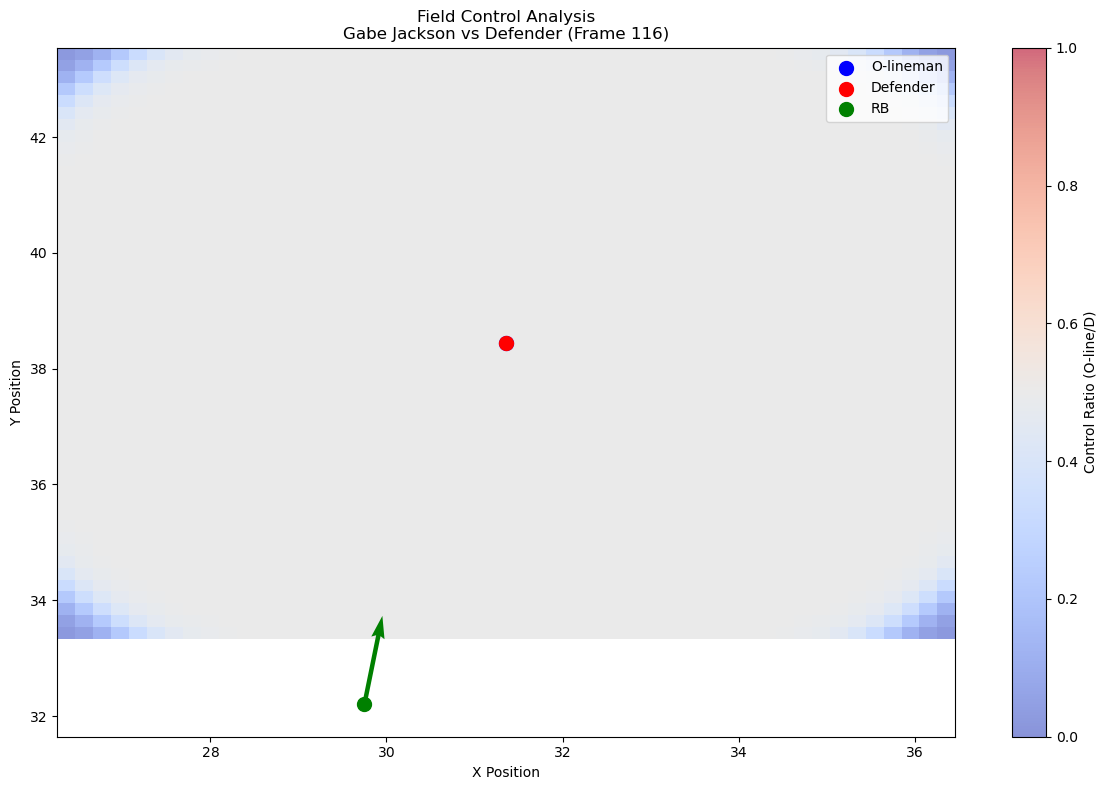

In [158]:
# Calculate grades for all plays
lineman_grades, detailed_results = calculate_field_control(tracking_with_breakthrough)

# View top performers
print(lineman_grades.sort_values('overall_grade', ascending=False).head(10))

# Visualize a specific play frame
play_example = detailed_results['game_play_id'].iloc[0]
frame_example = detailed_results[detailed_results['game_play_id'] == play_example]['frame_id'].iloc[10]
visualize_play_control(detailed_results[detailed_results['game_play_id'] == play_example], frame_example)